# Module 2.10 Validating the model

## Setup

### Imports

In [402]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Load data

In [403]:
# Load the training data
df_train = pd.read_csv('02-regression/notebooks/data_train.csv')

In [404]:
# Load the validation data
df_val = pd.read_csv('02-regression/notebooks/data_val.csv')

In [405]:
# Load the test data
df_test = pd.read_csv('02-regression/notebooks/data_test.csv')

## 2.10 Validating the model

### Notes

From https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/02-regression/10-car-price-validation.md

Calculation of the RMSE on validation partition of the dataset of car price prediction. In this way, we have a metric to evaluate the model's 
performance. 

### Implementation

In [406]:
# Let's select our feature columns
base = ['engine_hp', 'engine_cylinders',
        'highway_mpg', 'city_mpg', 'popularity']

In [407]:
# Target values
y_train = np.log1p(df_train.msrp.values)

# Target values for validation set
y_val = np.log1p(df_val.msrp.values)

In [408]:
def train_linear_regression(X, y):
    """Train linear regression model using the Normal Equation."""
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])  # add bias column of ones
    XTX = X.T.dot(X)  # Gram matrix
    XTX_inv = np.linalg.inv(XTX)  # inverse of Gram matrix
    w_full = XTX_inv.dot(X.T).dot(y)  # weights including bias

    return w_full[0], w_full[1:]  # return bias and weights

In [409]:
def prepare_X(df):
    """Prepare feature matrix from dataframe."""
    df_num = df[base]
    df_num = df_num.fillna(0)  # fill missing values with 0
    X = df_num.values
    return X

In [410]:
def rmse(y, y_pred):
    """Calculate Root Mean Squared Error."""
    se = (y - y_pred) ** 2  # squared errors
    mse = se.mean()  # mean squared error
    return np.sqrt(mse)  # root mean squared error

In [411]:
# Prepare the feature matrix for training data
X_train = prepare_X(df_train)
(w0, w) = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)

rmse(y_val, y_pred)

np.float64(0.739818428511342)

## 2.11 Feature engineering

### Notes

From https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/02-regression/11-feature-engineering.md

The feature age of the car was included in the dataset, obtained with the subtraction of the maximum year of cars and each of the years of cars. This new feature improved the model performance, measured with the RMSE and comparing the distributions of y target variable and predictions.

### Implementation

In [412]:
# What is the most recent year in the dataset? (What is the date of the dataset?)
year = df_train.year.max()
year

np.int64(2017)

In [413]:
# Create a new feature 'age'
def prepare_X(df_orig):
    """Prepare feature matrix from dataframe."""
    df = df_orig.copy()  # avoid changing the original dataframe

    df['age'] = year - df.year  # new 'age' feature
    features = base + ['age']  # add 'age' to the list of features

    df_num = df[features]  # select feature columns
    df_num = df_num.fillna(0)  # fill missing values with 0
    X = df_num.values

    return X

In [414]:
# Prepare the feature matrix for training data with the new 'age' feature
X_train = prepare_X(df_train)
(w0, w) = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)

rmse(y_val, y_pred)

np.float64(0.5133241025826346)

<Axes: ylabel='Count'>

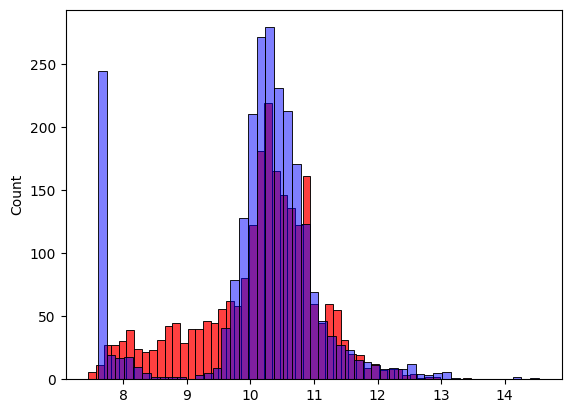

In [415]:
# Plot validation vs predicted values
sns.histplot(y_pred, color='red', bins=50)
sns.histplot(y_val, color='blue', alpha=0.5, bins=50)

## 2.12 Categorical variables

### Notes

From https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/02-regression/12-categorical-variables.md

Categorical variables are typically represented as strings, and pandas identifies them as object types. However, some variables that appear to be numerical may actually be categorical (e.g., the number of doors a car has). All these categorical variables need to be converted to a numerical form because ML models can interpret only numerical features. It is possible to incorporate certain categories from a feature, not necessarily all of them. This transformation from categorical to numerical variables is known as One-Hot encoding.

### Implementation

In [416]:
categorical_columns = [
    'make', 'model', 'engine_fuel_type', 'driven_wheels', 'market_category',
    'vehicle_size', 'vehicle_style']

categorical = {}

for c in categorical_columns:
    categorical[c] = list(df_train[c].value_counts().head().index)

In [ ]:
# Create new features age, and cetegorical features
def prepare_X(df_orig):
    """Prepare feature matrix from dataframe."""
    df = df_orig.copy()  # avoid changing the original dataframe
    features = base.copy()  # copy the base features

    # Age feature
    df['age'] = year - df.year  # new 'age' feature
    features.append('age')  # add 'age' to the list of features

    # Doors features
    for val in [2, 3, 4]:
        df[f'num_doors_{val}'] = (df.number_of_doors == val).astype(
            int)  # one-hot encoding
        features.append(f'num_doors_{val}')  # add door feature to the list

    for name, values in categorical.items():
        for value in values:
            df[f'{name}_{value}'] = (df[name] == value).astype(int)
            features.append(f'{name}_{value}')

    df_num = df[features]  # select feature columns
    df_num = df_num.fillna(0)  # fill missing values with 0
    X = df_num.values

    return X

In [418]:
# Prepare the feature matrix for training data with the new age and categorical features
X_train = prepare_X(df_train)
(w0, w) = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)

rmse(y_val, y_pred)

np.float64(11.974047956520602)

<Axes: ylabel='Count'>

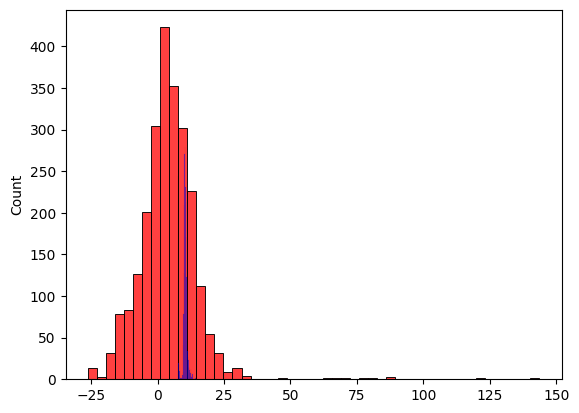

In [419]:
# Plot validation vs predicted values
sns.histplot(y_pred, color='red', bins=50)
sns.histplot(y_val, color='blue', alpha=0.5, bins=50)

## 2.13 Regularisation

### Notes

From https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/02-regression/13-regularization.md

If the feature matrix has duplicate columns (or columns that can be expressed as a linear combination of other columns), it will not have an inverse matrix. But, sometimes this error could be passed if certain values are slightly different between duplicated columns.

So, if we apply the normal equation with this feature matrix, the values associated with duplicated columns are very large, which decreases the model performance. To solve this issue, one alternative is adding a small number to the diagonal of the feature matrix, which corresponds to regularization.

This technique works because the addition of small values to the diagonal makes it less likely to have duplicated columns. The regularization value is a hyperparameter of the model. After applying regularization the model performance improved.

#### Comments
##### Linear combination

I mentioned the term *linear combination* in the video, but didn't explain what it means. 
So if you're interested what it means, you can read here

* One column is a linear combination of others when you can express one column of a matrix as a sum of others columns
* The simplest example is when a column is an exact duplicate of another column
* Another example. Let's say we have 3 columns: `a`, `b`, `c`. If `c = 0.2 * a + 0.5 * b`, then `c` is a linear combination of `a` and `b`
* More formal definition: https://en.wikipedia.org/wiki/Linear_combination

##### Ridge Regression
The regularization technique used (adding a factor to the diagonals of Gram Matrix) in this lesson is Ridge Regression. Further explanations are available in this [DataTalks.Club article](https://datatalks.club/blog/regularization-in-regression.html).

### Implementation

In [420]:
# Example
XTX = [
    [1, 2, 2],
    [2, 1, 1],
    [2, 1, 1]
]

XTX = np.array(XTX)
XTX

array([[1, 2, 2],
       [2, 1, 1],
       [2, 1, 1]])

In [421]:
# np.linalg.inv(XTX) # this will fail with a LinAlgError

In [422]:
# Make XTX almost singular
XTX = [
    [1, 2, 2],
    [2, 1, 1.0000001],
    [2, 1.0000001, 1]
]

XTX = np.array(XTX)
XTX

array([[1.       , 2.       , 2.       ],
       [2.       , 1.       , 1.0000001],
       [2.       , 1.0000001, 1.       ]])

In [ ]:
np.linalg.inv(XTX)  # Will work but with large numbers

array([[-3.33333356e-01,  3.33333339e-01,  3.33333339e-01],
       [ 3.33333339e-01, -5.00000008e+06,  4.99999991e+06],
       [ 3.33333339e-01,  4.99999991e+06, -5.00000008e+06]])

In [ ]:
# Add a small value to the diagonal (regularisation)
XTX = XTX + 0.01 * np.eye(3)  # add 0.01 to the diagonal
XTX

array([[1.01     , 2.       , 2.       ],
       [2.       , 1.01     , 1.0000001],
       [2.       , 1.0000001, 1.01     ]])

In [425]:
# Now it should work
# The larger the regularisation value, the smaller the weights in this example
np.linalg.inv(XTX)

array([[ -0.33668908,   0.33501399,   0.33501399],
       [  0.33501399,  49.91590897, -50.08509104],
       [  0.33501399, -50.08509104,  49.91590897]])

In [ ]:
def train_linear_regression_reg(X, y, reg=0.001):
    """Train linear regression model using the Normal Equation."""
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])  # add bias column of ones
    XTX = X.T.dot(X)  # Gram matrix

    # add regularization to the diagonal
    XTX = XTX + reg * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)  # inverse of Gram matrix
    w_full = XTX_inv.dot(X.T).dot(y)  # weights including bias

    return w_full[0], w_full[1:]  # return bias and weights

In [427]:
# Prepare the feature matrix for training data with regularisation
X_train = prepare_X(df_train)
(w0, w) = train_linear_regression_reg(X_train, y_train, 0.01)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)

rmse(y_val, y_pred)

np.float64(0.45620351314346075)

<Axes: ylabel='Count'>

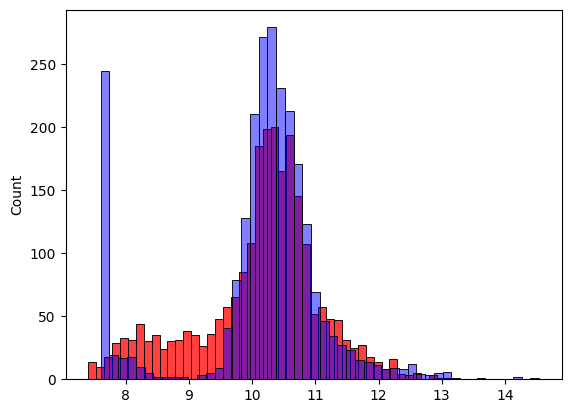

In [428]:
# Plot validation vs predicted values
sns.histplot(y_pred, color='red', bins=50)
sns.histplot(y_val, color='blue', alpha=0.5, bins=50)

## 2.14 Tuning the model

### Notes

From https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/02-regression/14-tuning-model.md

Tuning the model consisted of finding the best regularization hyperparameter value, using the validation partition of the dataset. The model was then trained with this regularization value.

### Implementation

In [ ]:
# Try different values of the regularisation parameter
for r in [0.0, 0.00001, 0.0001, 0.001, 0.1, 1, 10]:
    X_train = prepare_X(df_train)
    w0, w = train_linear_regression_reg(X_train, y_train, reg=r)

    X_val = prepare_X(df_val)
    y_pred = w0 + X_val.dot(w)
    score = rmse(y_val, y_pred)

    print(r, w0, score)

0.0 538575225087406.0 11.974047956520602
1e-05 7.236247247742298 0.4562224795745202
0.0001 7.236051099942988 0.45622230157444793
0.001 7.234175927493055 0.4562205097051638
0.1 7.045725784245137 0.456111058006034
1 6.140819742328392 0.457478481459754
10 4.720064528929132 0.4693391993895634


In [430]:
# Final model with regularisation parameter 0.001
reg = 0.001
X_train = prepare_X(df_train)
w0, w = train_linear_regression_reg(X_train, y_train, reg=reg)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)
score = rmse(y_val, y_pred)
print(score)

0.4562205097051638


## 2.15 Using the model

### Notes

From https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/02-regression/15-using-model.md

After finding the best model and its parameters, it was trained with training and validation partitions and the final RMSE was calculated on the test partition.

Finally, the final model was used to predict the price of new cars.

In [431]:
# Combine training and validation sets
df_full_train = pd.concat([df_train, df_val], ignore_index=True)
df_full_train

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,gmc,envoy_xl,2005,regular_unleaded,275.0,6.0,automatic,rear_wheel_drive,4.0,NaN,large,4dr_suv,18,13,549,29695
1,volkswagen,passat,2016,regular_unleaded,170.0,4.0,automatic,front_wheel_drive,4.0,NaN,midsize,sedan,38,25,873,30495
2,honda,odyssey,2016,regular_unleaded,248.0,6.0,automatic,front_wheel_drive,4.0,NaN,large,passenger_minivan,28,19,2202,37650
3,chevrolet,cruze,2015,regular_unleaded,138.0,4.0,manual,front_wheel_drive,4.0,NaN,midsize,sedan,36,25,1385,16170
4,volvo,740,1991,regular_unleaded,162.0,4.0,automatic,rear_wheel_drive,4.0,"luxury,performance",midsize,sedan,20,17,870,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9527,oldsmobile,lss,1999,regular_unleaded,240.0,6.0,automatic,front_wheel_drive,4.0,NaN,large,sedan,25,16,26,2681
9528,volkswagen,golf_sportwagen,2017,regular_unleaded,170.0,4.0,automatic,front_wheel_drive,4.0,NaN,compact,wagon,34,25,873,22680
9529,toyota,tundra,2016,regular_unleaded,310.0,8.0,automatic,rear_wheel_drive,4.0,NaN,large,extended_cab_pickup,19,15,2031,30950
9530,gmc,safari,2005,regular_unleaded,190.0,6.0,automatic,all_wheel_drive,3.0,NaN,large,passenger_minivan,16,12,549,26430


In [ ]:
# feature matrix for the combined dataset
X_full_train = prepare_X(df_full_train)
X_full_train

array([[275.,   6.,  18., ...,   0.,   0.,   0.],
       [170.,   4.,  38., ...,   0.,   0.,   0.],
       [248.,   6.,  28., ...,   0.,   0.,   0.],
       ...,
       [310.,   8.,  19., ...,   0.,   0.,   0.],
       [190.,   6.,  16., ...,   0.,   0.,   0.],
       [302.,   4.,  30., ...,   0.,   0.,   0.]], shape=(9532, 41))

In [ ]:
# target values for the combined dataset
y_full_train = np.concatenate([y_train, y_val])
y_full_train

array([10.29876764, 10.32535081, 10.53611479, ..., 10.34016059,
       10.18229284, 10.65374731], shape=(9532,))

In [ ]:
# normalise target values for the test set
y_test = np.log1p(df_test.msrp.values)

In [435]:
# Prepare the feature matrix for full training data
(w0, w) = train_linear_regression_reg(X_full_train, y_full_train, reg=0.001)

X_test = prepare_X(df_test)
y_pred = w0 + X_test.dot(w)

rmse(y_test, y_pred)

np.float64(0.4549486630446402)

### Use the model

In [436]:
# Prepare a single car for prediction, kinda like an API request object model
car = df_test.iloc[20].to_dict()
car

{'make': 'toyota',
 'model': 'tacoma',
 'year': 2015,
 'engine_fuel_type': 'regular_unleaded',
 'engine_hp': 236.0,
 'engine_cylinders': 6.0,
 'transmission_type': 'manual',
 'driven_wheels': 'four_wheel_drive',
 'number_of_doors': 4.0,
 'market_category': nan,
 'vehicle_size': 'compact',
 'vehicle_style': 'extended_cab_pickup',
 'highway_mpg': 19,
 'city_mpg': 15,
 'popularity': 2031,
 'msrp': 35725}

In [437]:
# We need to create a dataframe in this academic example
df_car = pd.DataFrame([car])
df_car

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,toyota,tacoma,2015,regular_unleaded,236.0,6.0,manual,four_wheel_drive,4.0,NaN,compact,extended_cab_pickup,19,15,2031,35725


In [438]:
# Prepare a feature matrix for the single car
X_car = prepare_X(df_car)
X_car

array([[2.360e+02, 6.000e+00, 1.900e+01, 1.500e+01, 2.031e+03, 2.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]])

In [439]:
# Make a prediction
y_pred = w0 + X_car.dot(w)
print(y_pred)

[10.52516056]


In [440]:
# Undo the logorithm and extract the price
car_price = np.expm1(y_pred)[0]
print(car_price)

37239.812969102735


In [ ]:
# The actual values
test_price = np.expm1(y_test[20])
diff = (car_price - test_price).round(2)
print(
    f'Difference between predicted car_price={car_price.round(2)} and test_price={test_price.round(2)}\ndiff={diff}')

Difference between predicted car_price=37239.81 and test_price=35725.0
diff=1514.81


## 2.17 More
In this project, we included only 5 top features. What happens if we include 10?

In [ ]:
categorical = {}

for c in categorical_columns:
    categorical[c] = list(df_train[c].value_counts().head(10).index)  # top 10


def train_linear_regression_reg(X, y, reg=0.001):
    """Train linear regression model using the Normal Equation."""
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])  # add bias column of ones
    XTX = X.T.dot(X)  # Gram matrix

    # add regularization to the diagonal
    XTX = XTX + reg * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)  # inverse of Gram matrix
    w_full = XTX_inv.dot(X.T).dot(y)  # weights including bias

    return w_full[0], w_full[1:]  # return bias and weights

In [445]:
# Final model with regularisation parameter 0.001
reg = 0.001
X_train = prepare_X(df_train)
w0, w = train_linear_regression_reg(X_train, y_train, reg=reg)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)
score = rmse(y_val, y_pred)
print(score)

0.4414349744610127


The RMSE lowered.